## Data preprocessing

### Data download

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip -q "/content/drive/MyDrive/Colab Notebooks/Monkeypox Data/Custom Dataset.zip"

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
train_dir = '/content/train'
validation_dir = '/content/val'
test_dir = '/content/test'

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 1772 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 94 files belonging to 2 classes.


In [ ]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 288 files belonging to 2 classes.


In [ ]:
class_names = train_dataset.class_names

# Below code is for visualizing a few images from the dataset

#plt.figure(figsize=(10, 10))
#for images, labels in train_dataset.take(1):
#  for i in range(9):
#    ax = plt.subplot(3, 3, i + 1)
#    plt.imshow(images[i].numpy().astype("uint8"))
#    plt.title(class_names[labels[i]])
#    plt.axis("off")

### Configure the dataset for performance

In [ ]:
# Used prefetching into a buffer to load data into memory
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Rescale pixel values

In [ ]:
# Application specific preprocessing is used to ensure pixel values are in the range of the model
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Create the base model from the pre-trained convnets

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
# Include_top=False means the model will not include the classification layer at the top
# as we will be adding our own
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
# unit test batch
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

## Feature extraction

### Freeze the convolutional base

In [ ]:
# Base model is frozen to prevent weights of the pre-trained model from being updated during initial training
base_model.trainable = False

### Add a classification head

Average pooling was chosen as a dimension reducer as it can smooth out spatial variations in the input images, improving the performance of the CNN by making it more robust to position and orientation variations in the Mpox lesions.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

To convert the features into a single prediction per image, a Dense layer is applied. An activation function isn't required because the prediction will be treated as a logit (raw prediction value).

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
# Model is created by chaining together the base model, global average layer, and prediction layer
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

In [ ]:
# Model is compiled with binary crossentropy loss, Adam optimizer and binary accuracy metric
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

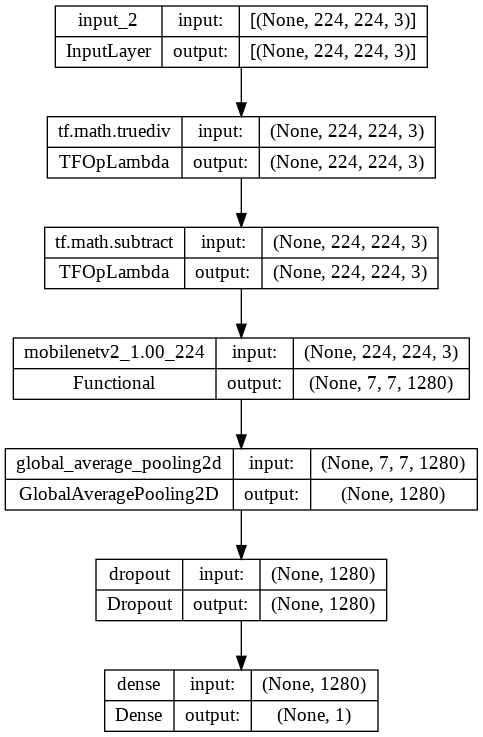

In [ ]:
plot_model(model, to_file='Mobilenet_model_plot.png', show_shapes=True, show_layer_names=True)

### Train the model

In [ ]:
# large number of epochs is used to ensure the model is trained long enough 
# to reach convergence and a good accuracy
initial_epochs = 100

loss0, accuracy0 = model.evaluate(validation_dataset)

3/3 [==============================] - 2s 226ms/step - loss: 0.9272 - binary_accuracy: 0.3298


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.93
initial accuracy: 0.33


In [ ]:
# early stopping is used to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[early_stopping])

Epoch 1/100
56/56 [==============================] - 8s 63ms/step - loss: 0.8608 - binary_accuracy: 0.4317 - val_loss: 0.7305 - val_binary_accuracy: 0.4894
Epoch 2/100
56/56 [==============================] - 3s 53ms/step - loss: 0.7441 - binary_accuracy: 0.5209 - val_loss: 0.6167 - val_binary_accuracy: 0.6064
Epoch 3/100
56/56 [==============================] - 3s 55ms/step - loss: 0.6485 - binary_accuracy: 0.5971 - val_loss: 0.5371 - val_binary_accuracy: 0.6702
Epoch 4/100
56/56 [==============================] - 3s 54ms/step - loss: 0.5912 - binary_accuracy: 0.6586 - val_loss: 0.4858 - val_binary_accuracy: 0.7340
Epoch 5/100
56/56 [==============================] - 3s 53ms/step - loss: 0.5575 - binary_accuracy: 0.6907 - val_loss: 0.4423 - val_binary_accuracy: 0.8085
Epoch 6/100
56/56 [==============================] - 3s 54ms/step - loss: 0.5140 - binary_accuracy: 0.7212 - val_loss: 0.4119 - val_binary_accuracy: 0.8085
Epoch 7/100
56/56 [==============================] - 3s 54ms/ste

In [ ]:
# Save number of epochs run to use for plotting
primary_epochs = len(history.history['loss'])

### Learning curves

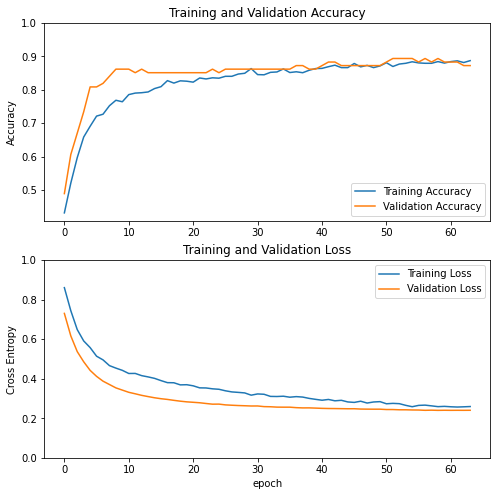

In [29]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

### Un-freeze the top layers of the model


In [30]:
# Allowing the layers of the base model to be trainable
base_model.trainable = True

In [31]:
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile the model

In [32]:
# Compile the model using a lower training rate to prevent large weight updates
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['binary_accuracy'])

In [33]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

### Continue training the model

In [35]:
# Seperate early stopping is used for fine tuning to prevent overfitting
fine_early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

In [36]:
fine_tune_epochs = 10
total_epochs =  primary_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[fine_early_stopping])

Epoch 64/74
56/56 [==============================] - 10s 85ms/step - loss: 0.2619 - binary_accuracy: 0.8787 - val_loss: 0.2165 - val_binary_accuracy: 0.9149
Epoch 65/74
56/56 [==============================] - 4s 67ms/step - loss: 0.2063 - binary_accuracy: 0.9080 - val_loss: 0.1978 - val_binary_accuracy: 0.9043
Epoch 66/74
56/56 [==============================] - 4s 67ms/step - loss: 0.1915 - binary_accuracy: 0.9204 - val_loss: 0.1914 - val_binary_accuracy: 0.9043
Epoch 67/74
56/56 [==============================] - 4s 68ms/step - loss: 0.1504 - binary_accuracy: 0.9385 - val_loss: 0.1786 - val_binary_accuracy: 0.9043
Epoch 68/74
56/56 [==============================] - 4s 67ms/step - loss: 0.1215 - binary_accuracy: 0.9616 - val_loss: 0.2157 - val_binary_accuracy: 0.9255


In [40]:
# save model
model.save('Mpox Mobilenet.h5')

In [37]:
# append fine tuning results to primary results
acc += history_fine.history['binary_accuracy']
val_acc += history_fine.history['val_binary_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

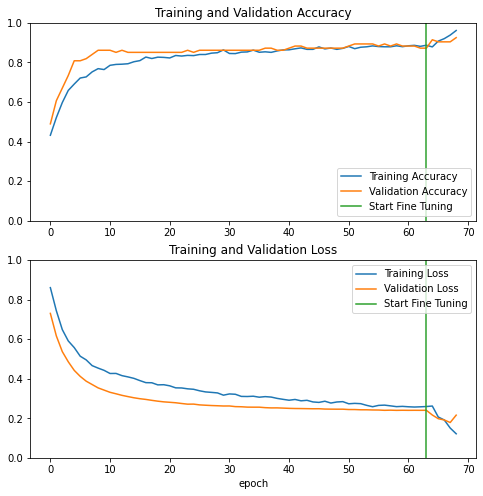

In [38]:
# Plot results
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([primary_epochs-1, primary_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([primary_epochs-1, primary_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

In [39]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

9/9 [==============================] - 1s 49ms/step - loss: 0.3089 - binary_accuracy: 0.8889


[0.3089035153388977, 0.8888888955116272]

Labels:
 [1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 1]


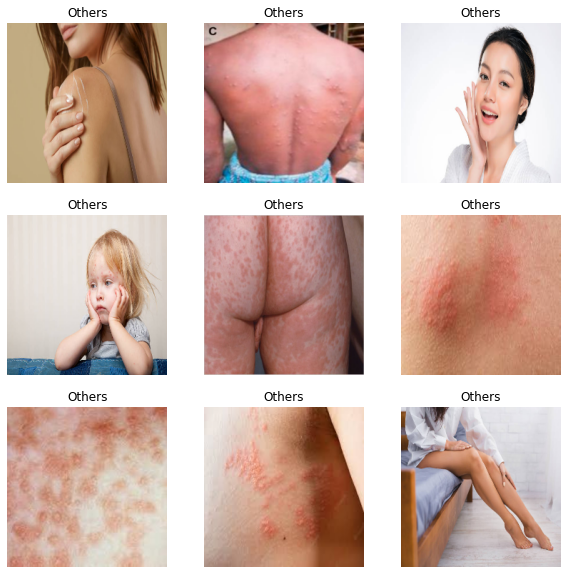

In [41]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [42]:
# Generate and collect predictions for all images in the test set

prediction_arrays = []
label_arrays = []

for images, labels in test_dataset.take(9):
    predictions = model.predict_on_batch(images).flatten()
    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(predictions)
    predictions = tf.where(predictions < 0.5, 0, 1)
    predictions = predictions.numpy()
    prediction_arrays.append(predictions)
    label_arrays.append(labels)

all_predictions = np.concatenate(prediction_arrays).ravel()
all_labels = np.concatenate(label_arrays).ravel()

#print('Predictions:\n', all_predictions)
#print('Labels:\n', all_labels)

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

# generate precision, recall, f-measure and accuracy for each class
print(classification_report(all_labels, all_predictions, target_names=class_names))

# generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

              precision    recall  f1-score   support

   Monkeypox       0.91      0.78      0.84       106
      Others       0.88      0.96      0.92       182

    accuracy                           0.89       288
   macro avg       0.90      0.87      0.88       288
weighted avg       0.89      0.89      0.89       288



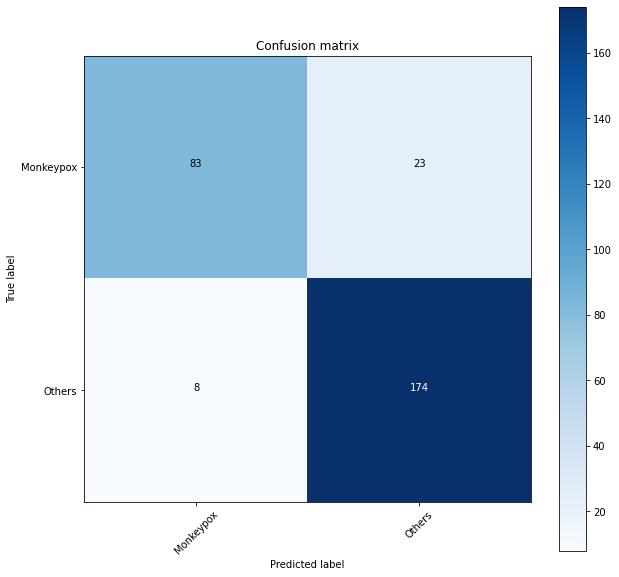

In [44]:
import itertools

# plot confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

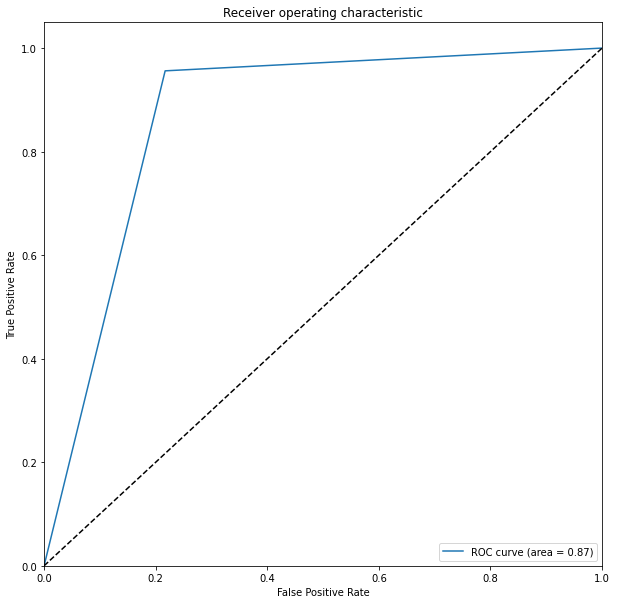

In [45]:
# plot auc curve

fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()